# Python implementation of Frank-Wolfe algorithm for NNM with sparse

penalty

Saikat Banerjee  
2023-07-29

Impelement an algorithm for nuclear norm minimization + sparse penalty
(best of both worlds?)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [11]:
ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

In [12]:
Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 0.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)

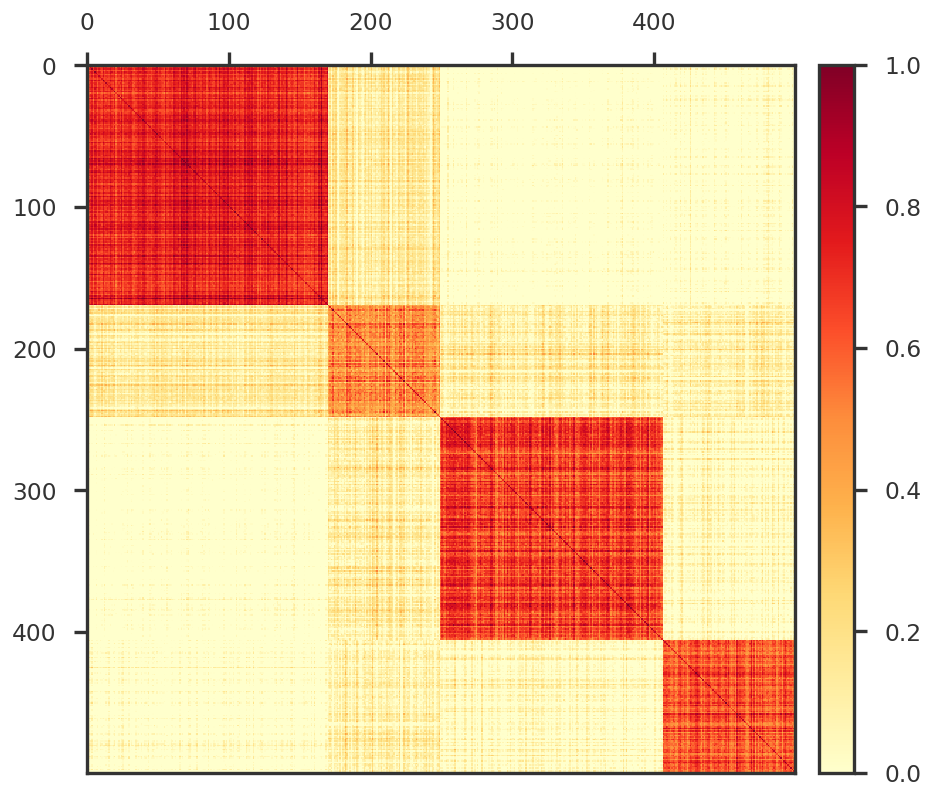

In [13]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, L)

plt.tight_layout()
plt.show()

In [14]:
np.linalg.matrix_rank(Y_true)

40

In [15]:
np.linalg.matrix_rank(Y_cent)

499

In [16]:
np.linalg.norm(Y_cent, ord = 'nuc')

6932.244652345258

In [17]:
np.linalg.norm(Y_std, ord = 'nuc')

13368.766978646658

In [18]:
np.linalg.norm(Y_true, ord = 'nuc')

584.4221920551713

In [32]:
idx = np.unravel_index(np.argmax(Y_true), Y_true.shape)

In [33]:
np.max(Y_true)

0.8948086870272697

In [34]:
Y_true[idx]

0.8948086870272697

In [39]:
from sklearn.utils.extmath import randomized_svd

def proj_simplex_sort(y, a = 1.0):
    if np.sum(y) == a and np.alltrue(y >= 0):
        return y
    u = np.sort(y)[::-1]
    ukvals = (np.cumsum(u) - a) / np.arange(1, y.shape[0] + 1)
    K = np.nonzero(ukvals < u)[0][-1]
    tau = ukvals[K]
    x = np.clip(y - tau, a_min=0, a_max=None)
    return x

def proj_l1ball_sort(y, a = 1.0):
    if y.ndim == 2:
        n, p = y.shape
        yflat = y.flatten()
        yproj = np.sign(y) * proj_simplex_sort(np.abs(yflat), a = a).reshape(n, p)
    else:
        yproj = np.sign(y) * proj_simplex_sort(np.abs(yflat), a = a).reshape(n, p)
    return yproj

def l1_norm(x):
    return np.sum(np.abs(x))

def nuclear_norm(X):
    '''
    Nuclear norm of input matrix
    '''
    return np.sum(np.linalg.svd(X)[1])

def f_objective(X, Y, W = None, mask = None):
    '''
    Objective function
    Y is observed, X is estimated
    W is the weight of each observation.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    # The * operator can be used as a shorthand for np.multiply on ndarrays.
    if Wmask is None:
        f_obj = 0.5 * np.linalg.norm(Y - Xmask, 'fro')**2
    else:
        f_obj = 0.5 * np.linalg.norm(Wmask * (Y - Xmask), 'fro')**2
    return f_obj


def f_gradient(X, Y, W = None, mask = None):
    '''
    Gradient of the objective function.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    if Wmask is None:
        f_grad = Xmask - Y
    else:
        f_grad = np.square(Wmask) * (Xmask - Y)
    
    return f_grad

def linopt_oracle_l1norm(grad, r = 1.0, max_iter = 10):
    '''
    Linear optimization oracle,
    where the feasible region is a l1 norm ball for some r
    '''
    maxidx = np.unravel_index(np.argmax(grad), grad.shape)
    S = np.zeros_like(grad)
    S[maxidx] = - r
    return S


def linopt_oracle_nucnorm(grad, r = 1.0, max_iter = 10, method = 'power'):
    '''
    Linear optimization oracle,
    where the feasible region is a nuclear norm ball for some r
    '''
    if method == 'power':
        U1, V1_T = singular_vectors_power_method(grad, max_iter = max_iter)
    elif method == 'randomized':
        U1, V1_T = singular_vectors_randomized_method(grad, max_iter = max_iter)
    S = - r * U1 @ V1_T
    return S


def singular_vectors_randomized_method(X, max_iter = 10):
    u, s, vh = randomized_svd(X, n_components = 1, n_iter = max_iter,
                              power_iteration_normalizer = 'none',
                              random_state = 0)
    return u, vh


def singular_vectors_power_method(X, max_iter = 10):
    '''
    Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        X : array {m, n},
            input matrix
        max_iter : integer, optional
            number of steps
            
    Returns:
    --------
        u, v : (n, 1), (p, 1)
            two arrays representing approximate top left and right
            singular vectors.
    '''
    n, p = X.shape
    u = np.random.normal(0, 1, n)
    u /= np.linalg.norm(u)
    v = X.T.dot(u)
    v /= np.linalg.norm(v)
    for _ in range(max_iter):      
        u = X.dot(v)
        u /= np.linalg.norm(u)
        v = X.T.dot(u)
        v /= np.linalg.norm(v)       
    return u.reshape(-1, 1), v.reshape(1, -1)


def do_step_size(dg, D, W = None, old_step = None):
    if W is None:
        denom = np.linalg.norm(D, 'fro')**2
    else:
        denom = np.linalg.norm(W * D, 'fro')**2
    step_size = dg / denom
    step_size = min(step_size, 1.0)
    if step_size < 0:
        print ("Warning: Step Size is less than 0")
        if old_step is not None and old_step > 0:
            print ("Using previous step size")
            step_size = old_step
        else:
            step_size = 1.0
    return step_size


def frank_wolfe_minimize_step(L, M, Y, rl, rm, istep, W = None, mask = None, old_step = None, svd_iter = None, svd_method = 'power'):
    #
    # 1. Gradient for X_(t-1)
    #
    G = f_gradient(L + M, Y, W = W, mask = mask)
    #
    # 2. Linear optimization subproblem
    #
    if svd_iter is None: 
        svd_iter = 10 + int(istep / 20)
        svd_iter = min(svd_iter, 25)
    SL = linopt_oracle_nucnorm(G, rl, max_iter = svd_iter, method = svd_method)
    SM = linopt_oracle_l1norm(G, rm)
    #
    # 3. Define D
    #
    DL = L - SL
    DM = M - SM
    #
    # 4. Duality gap
    #
    dg = np.trace(DL.T @ G) + np.trace(DM.T @ G)
    #
    # 5. Step size
    #
    step = do_step_size(dg, DL + DM, W = W, old_step = old_step)
    #
    # 6. Update
    #
    Lnew = L - step * DL
    Mnew = M - step * DM
    #
    # 7. l1 projection
    #
    G_half = f_gradient(Lnew + Mnew, Y, W = W, mask = mask)
    Mnew = proj_l1ball_sort(Mnew - G_half, rm)
    return Lnew, Mnew, G, dg, step


def frank_wolfe_minimize(Y, r, X0 = None,
                         weight = None,
                         mask = None,
                         max_iter = 1000,
                         svd_iter = None,
                         svd_method = 'power',
                         tol = 1e-4, step_tol = 1e-3, rel_tol = 1e-8,
                         return_all = True,
                         debug = False, debug_step = 10):
    
    rl, rm = r
    
    # Step 0
    old_L = np.zeros_like(Y) if X0 is None else X0.copy()
    old_M = np.zeros_like(Y)
    dg = np.inf
    step = 1.0

    if return_all:
        dg_list = [dg]
        fx_list = [f_objective(old_L + old_M, Y, W = weight, mask = mask)]
        fl_list = [f_objective(old_L, Y, W = weight, mask = mask)]
        fm_list = [f_objective(old_M, Y, W = weight, mask = mask)]
        st_list = [1]
        
    # Steps 1, ..., max_iter
    for istep in range(max_iter):
        L, M, G, dg, step = \
            frank_wolfe_minimize_step(old_L, old_M, Y, rl, rm, istep, W = weight, mask = mask, old_step = step, svd_iter = svd_iter, svd_method = svd_method)
        f_obj = f_objective(L + M, Y, W = weight, mask = mask)
        fl_obj = f_objective(L, Y, W = weight, mask = mask)
        fm_obj = f_objective(M, Y, W = weight, mask = mask)
        fx_list.append(f_obj)
        fl_list.append(fl_obj)
        fm_list.append(fm_obj)

        if return_all:
            dg_list.append(dg)
            st_list.append(step)
        
        if debug:
            if (istep % debug_step == 0):
                print (f"Iteration {istep}. Step size {step:.3f}. Duality Gap {dg:g}")
                
        # Stopping criteria
        # duality gap
        if np.abs(dg) <= tol:
            break
        # step size
        if step > 0 and step <= step_tol:
            break
        # relative tolerance of objective function
        f_rel = np.abs((f_obj - fx_list[-2]) / f_obj)
        if f_rel <= rel_tol:
            break
            
        old_L = L.copy()
        old_M = M.copy()
        
    if return_all:
        return L, M, dg_list, fx_list, st_list, fl_list, fm_list
    else:
        return L, M

In [41]:
L_opt, M_opt, dg_list, fx_list, step_list, fl_list, fm_list = \
    frank_wolfe_minimize(
        Y_cent, (40.0, 10.0), max_iter = 1000, debug = True, debug_step = 100, step_tol = 1e-4, svd_iter=20)

Iteration 0. Step size 1.000. Duality Gap 3001.78
Using previous step size
Using previous step size
Using previous step size
Using previous step size
Using previous step size
Using previous step size

In [45]:
l1_norm(M_opt)

10.000000000000005

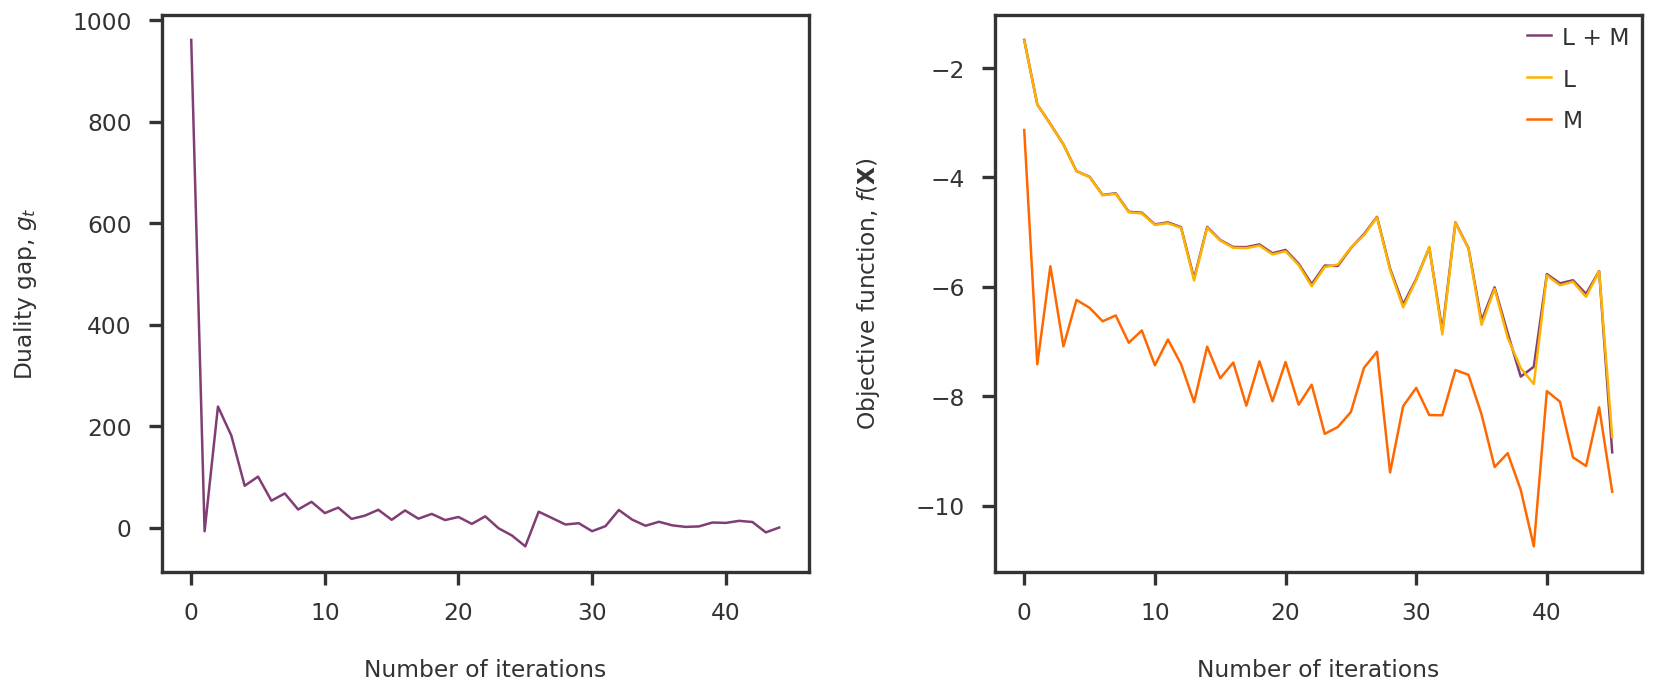

In [50]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

def relative_diff_log10(xlist):
    x_arr = np.array(xlist)
    x_ = np.log10(np.abs(np.diff(x_arr) / x_arr[1:]))
    return x_

kp = len(step_list)

ax1.plot(np.arange(kp - 2), dg_list[2:kp])
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")

# ax2.plot(np.arange(kp - 1), np.log10(fx_list[1:kp]))
ax2.plot(np.arange(kp - 1), relative_diff_log10(fx_list), label = "L + M")
ax2.plot(np.arange(kp - 1), relative_diff_log10(fl_list), label = "L")
ax2.plot(np.arange(kp - 1), relative_diff_log10(fm_list), label = "M")
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
ax2.legend()

fig.tight_layout(w_pad = 2.0)
plt.show()

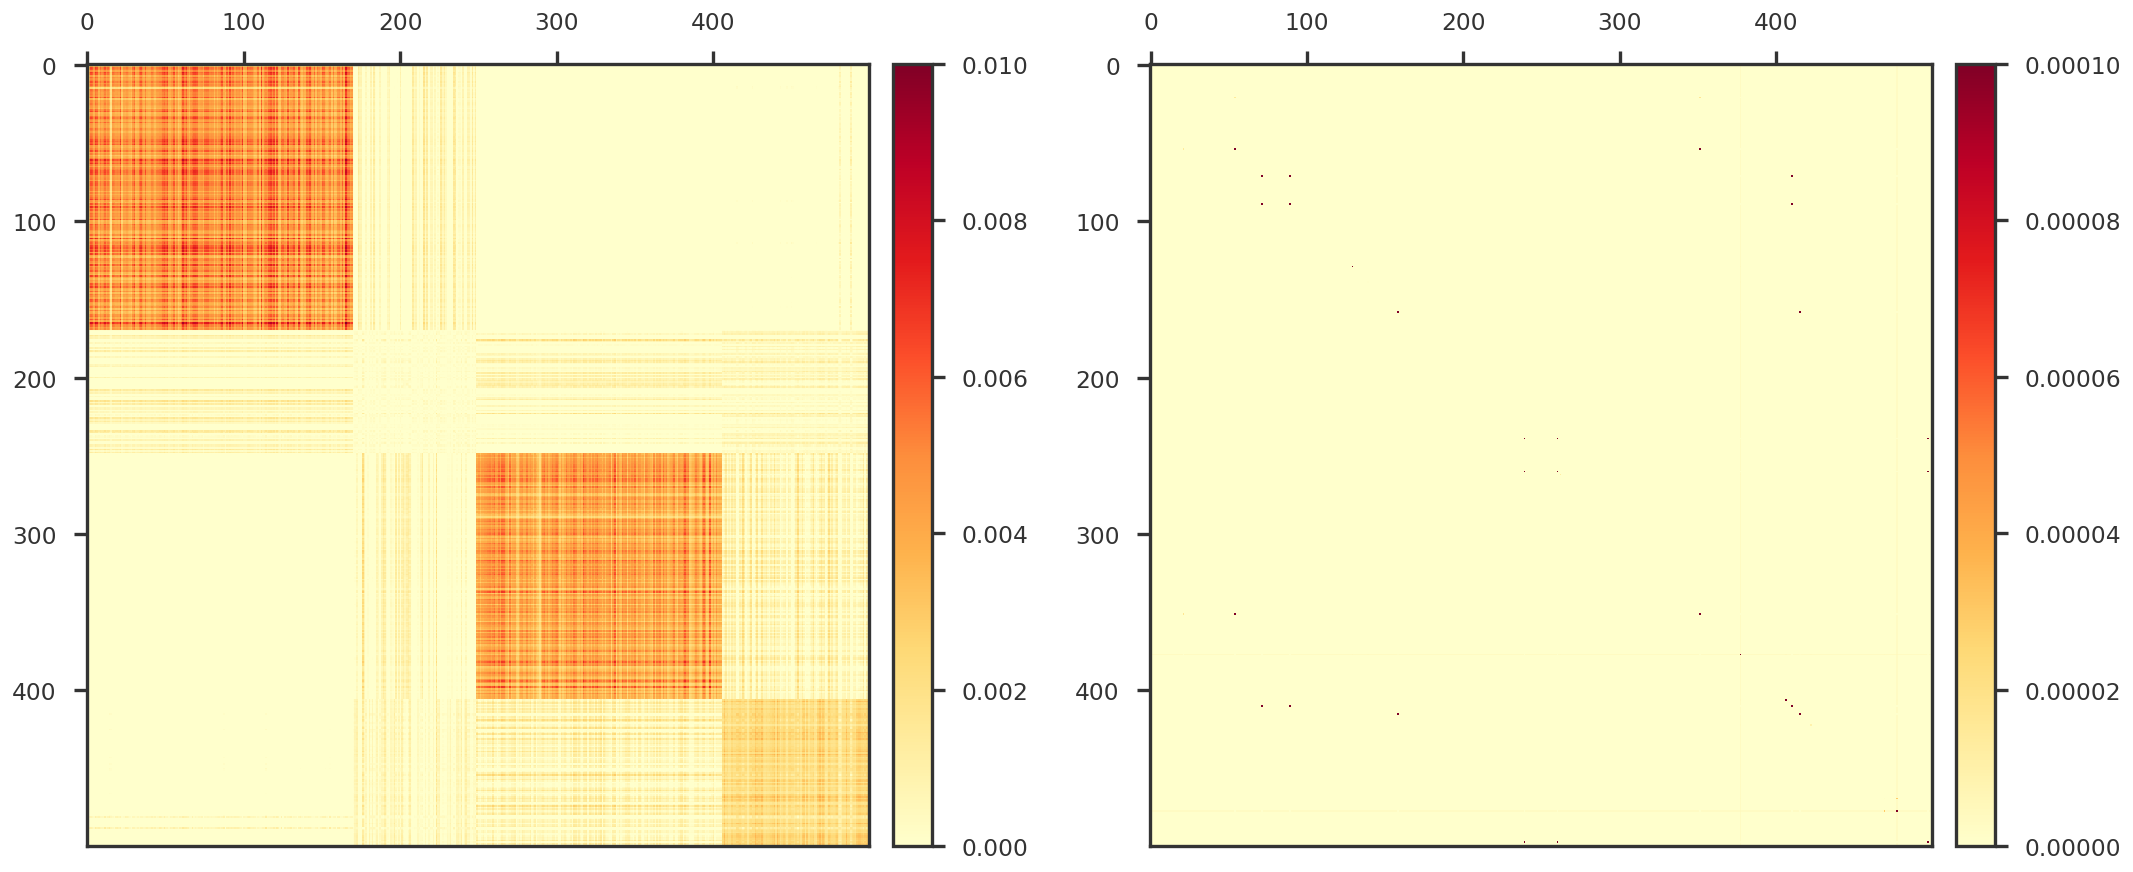

In [55]:
U1, S1, Vt1 = np.linalg.svd(mpy_simulate.do_standardize(L_opt, scale = False), full_matrices=False)
U2, S2, Vt2 = np.linalg.svd(mpy_simulate.do_standardize(M_opt, scale = False), full_matrices=False)

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mpy_plotfn.plot_covariance_heatmap(ax1, U1 @ np.diag(S1), vmax = 0.01)
mpy_plotfn.plot_covariance_heatmap(ax2, U2 @ np.diag(S2), vmax = 0.0001)

plt.tight_layout(w_pad=2.0)
plt.show()